
# Course Completion Prediction (On Kaggle)
##CSE 416 Introduction to Machine Learning 
##Assignment 5 

Sophia He 

July 28, 2020

This is a course-wide competition on Kaggle for CSE 416 at the University of Washington, via https://www.kaggle.com/c/cse-stat-416-sum-20/data. The objective is to investigate edX (anonymized) student data to try to predict whether a student received a certification (completed) a course. In this iPython Notebook, I explain my methods for data investigation, feature selection, and model training and evaluation.

In [ ]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
save_file('https://homes.cs.washington.edu/~vinitra/cse416/a5/edx_train.csv', 'edx_train.csv') 
save_file('https://homes.cs.washington.edu/~vinitra/cse416/a5/edx_test.csv', 'edx_test.csv')

In [ ]:
import warnings

import matplotlib.pyplot as plt # for graphing
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set()

# Investigate Data

I started out by importing the test and train data and looking at the train data. I verified that the training data has an extra 'certified' feature that the test data does not have, which will be the target.

In [ ]:
edx_data = pd.read_csv('edx_train.csv')
edx_test = pd.read_csv('edx_test.csv')    # csv file with only features
print(list(edx_data.columns))

print(list(edx_test.columns))

['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']
['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']


In [ ]:
edx_data.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130288921,1,0,0,0,Unknown/Other,Bachelor's,1988.0,m,8/30/12,unk,0.0,0.0,0.0,0.0,0
1,HarvardX/PH207x/2012_Fall,MHxPC130043703,1,1,1,1,India,Doctorate,1970.0,m,9/4/12,1/16/13,2550.0,21.0,10.0,14.0,0
2,HarvardX/CS50x/2012,MHxPC130082773,1,1,0,0,United States,Master's,1983.0,m,2/12/13,2/12/13,10.0,1.0,0.0,1.0,0
3,HarvardX/PH207x/2012_Fall,MHxPC130186614,1,1,1,1,Other Africa,Bachelor's,1984.0,m,10/16/12,1/15/13,6015.0,50.0,616.0,15.0,0
4,HarvardX/CS50x/2012,MHxPC130113075,1,1,0,0,United States,Secondary,1997.0,m,4/11/13,4/12/13,6.0,2.0,0.0,1.0,0


I then looked at distribution plots for a couple of features in the training data, to better visualize the data categories.

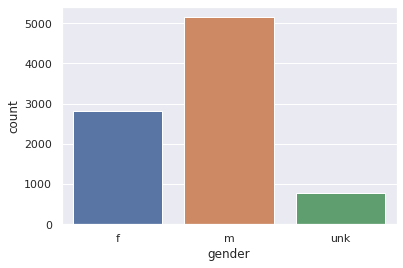

In [ ]:
sns.countplot(x='gender', data=edx_data, order=sorted(edx_data['gender'].unique()))

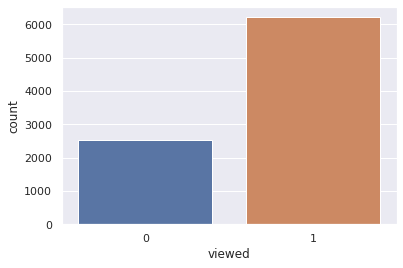

In [ ]:
sns.countplot(x='viewed', data=edx_data, order=sorted(edx_data['viewed'].unique()))

In the training data, I looked at the split between certified and not certified, in the column of the target feature.

In [ ]:
only_certified = edx_data[edx_data['certified'] == 1]
only_not_certified = edx_data[edx_data['certified'] == 0]

print(f'Number certified: {len(only_certified)} ({len(only_certified) * 100.0 / len(edx_data):.2f}%)')
print(f'Number not certified: {len(only_not_certified)} ({len(only_not_certified) * 100.0 / len(edx_data):.2f}%)')

Number certified: 3826 (43.69%)
Number not certified: 4932 (56.31%)


# Feature Selection

To start off with feature selection, I listed all the features in the training data.

In [ ]:
list(edx_data.columns)

['course_id',
 'userid_DI',
 'registered',
 'viewed',
 'explored',
 'certified',
 'final_cc_cname_DI',
 'LoE_DI',
 'YoB',
 'gender',
 'start_time_DI',
 'last_event_DI',
 'nevents',
 'ndays_act',
 'nplay_video',
 'nchapters',
 'nforum_posts']

Following, I defined a features array (shown below) and commented out the features to exclude. Initially, the only features excluded were 'userid_DI' (as suggested on the Kaggle page), as well as 'start_time_DI' because of the high variation from date to date (too many categories) and 'last_event_DI' for the same reason, as well as because nevents already gave a metric related to interaction with the course. 

After creating my first model (a decision tree) I came back and commented out two other features that were negatively impacting accuracy, 'final_cc_cname_DI' and 'LoE_DI'.

I chose not to reformat the data and keep the 'unk' and -1 representing unknowns as is because for many features there was no way to average them or find an appropriate way to recategorize them (such as with gender). I did not want to place any assumptions that would mis-categorize all unknowns for a feature and skew the data.

I then tried three more models: Random Forest, AdaBoost, and K Nearest Neighbor. I compared the resulting validation accuracies from these three models with the decision tree with the max depth with the best accuracy, and I found that Random Forest resulted in the best accuracy overall. I then changed the features once more to attain the best possible Random Forest accuracy, resulting in the features you see below. The excluded features are commented out.

In [ ]:
# Feature Set
features = [  
    'course_id',                # institution, course name, semester
    #'userid_DI',               # id number
    'registered',               # 0/1 registered for course = 1
    'viewed',                   # 0/1 anyone  who accessed  the ‘Courseware’  tab 
    'explored',                 # 0/1;  anyone  who accessed  at  least half  of  the chapters
    #'final_cc_cname_DI',       # country or continent/region
    'LoE_DI',                  # user provided highest level of education
    'YoB',                      # user provided year of birth
    'gender',                   # user provided gender m, f, or o
    #'start_time_DI',           # date of course registration
    #'last_event_DI',           # date of last interaction with course
    'nevents',                  # number of interactions with the course
    'ndays_act',                # number of unique days student interacted with course
    'nplay_video',              # number of play video  events within the course
    'nchapters',                # number of chapters with which the student interacted
    'nforum_posts',             # number of posts to the Discussion Forum. 
]


target = 'certified'                   # prediction target (y) (1 means certified, 0 is not certified)

# Extract the feature columns and target column
edx_data = edx_data[features + [target]]
edx_data.head()

,course_id,registered,viewed,explored,LoE_DI,YoB,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,certified
0,HarvardX/CS50x/2012,1,0,0,Bachelor's,1988.0,m,0.0,0.0,0.0,0.0,0,0
1,HarvardX/PH207x/2012_Fall,1,1,1,Doctorate,1970.0,m,2550.0,21.0,10.0,14.0,0,1
2,HarvardX/CS50x/2012,1,1,0,Master's,1983.0,m,10.0,1.0,0.0,1.0,0,0
3,HarvardX/PH207x/2012_Fall,1,1,1,Bachelor's,1984.0,m,6015.0,50.0,616.0,15.0,0,1
4,HarvardX/CS50x/2012,1,1,0,Secondary,1997.0,m,6.0,2.0,0.0,1.0,0,0


Because many categories had non-numerical data, for preprocessing I used one-hot encoding via the get_dummies() method; though it introduced sparsity into the dataset, it resulted in numerical values for the non-numerical categories.

In [ ]:
edx_data = pd.get_dummies(edx_data)
features = list(edx_data.columns)
features.remove('certified')
features

['registered',
 'viewed',
 'explored',
 'YoB',
 'nevents',
 'ndays_act',
 'nplay_video',
 'nchapters',
 'nforum_posts',
 'course_id_HarvardX/CB22x/2013_Spring',
 'course_id_HarvardX/CS50x/2012',
 'course_id_HarvardX/ER22x/2013_Spring',
 'course_id_HarvardX/PH207x/2012_Fall',
 'course_id_HarvardX/PH278x/2013_Spring',
 "LoE_DI_Bachelor's",
 'LoE_DI_Doctorate',
 'LoE_DI_Less than Secondary',
 "LoE_DI_Master's",
 'LoE_DI_Secondary',
 'LoE_DI_unk',
 'gender_f',
 'gender_m',
 'gender_unk']

In [ ]:
edx_data.head()

,registered,viewed,explored,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,certified,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,LoE_DI_unk,gender_f,gender_m,gender_unk
0,1,0,0,1988.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,1,1,1,1970.0,2550.0,21.0,10.0,14.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,1,1,0,1983.0,10.0,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,1,1,1,1984.0,6015.0,50.0,616.0,15.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,1,1,0,1997.0,6.0,2.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


# Model Training and Evaluation

To train the models, I split the train data using train_test_split, to get both a train and validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(edx_data, test_size=0.2, random_state=1)

## Decision Tree Classifier

I started out with the decision tree classifier, testing with a small tree of max depth 2, mid-sized tree with max depth 5, and big tree with max depth 10. Out of these three models, the mid-sized tree with max depth 6 resulted in the best validation data accuracy. As mentioned above, I then reselected and commented out two additional features 'final_cc_cname_DI' and 'LoE_DI', which increased the validation accuracy for the mid-sized tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# mid sized tree
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=1)
decision_tree_model.fit(train_data[features], train_data[target])

# small tree
from sklearn import tree
small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=1)
small_tree_model.fit(train_data[features], train_data[target])

# big tree
big_tree_model = DecisionTreeClassifier(max_depth=10, random_state=1)
big_tree_model.fit(train_data[features], train_data[target])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
from sklearn.metrics import accuracy_score

# small tree accuracy comparison
small_tree_val_prediction = small_tree_model.predict(validation_data[features])
small_tree_train_prediction = small_tree_model.predict(train_data[features])
small_tree_val_acc = accuracy_score(small_tree_val_prediction, validation_data[target])
small_tree_train_acc = accuracy_score(small_tree_train_prediction, train_data[target])

print("small tree validation accuracy:", small_tree_val_acc)
print("small tree training accuracy:", small_tree_train_acc)

small tree validation accuracy: 0.9503424657534246
small tree training accuracy: 0.9511846988295747


In [ ]:
# mid sized tree accuracy comparison
decision_tree_val_prediction = decision_tree_model.predict(validation_data[features])
decision_tree_train_prediction = decision_tree_model.predict(train_data[features])
decision_tree_val_acc = accuracy_score(decision_tree_val_prediction, validation_data[target])
decision_tree_train_acc = accuracy_score(decision_tree_train_prediction, train_data[target])

print("decision tree validation accuracy:", decision_tree_val_acc)
print("decision tree training accuracy:", decision_tree_train_acc)

decision tree validation accuracy: 0.9714611872146118
decision tree training accuracy: 0.9737367970311162


In [ ]:
# big tree accuracy comparison
big_tree_val_prediction = big_tree_model.predict(validation_data[features])
big_tree_train_prediction = big_tree_model.predict(train_data[features])
big_tree_val_acc = accuracy_score(big_tree_val_prediction, validation_data[target])
big_tree_train_acc = accuracy_score(big_tree_train_prediction, train_data[target])

print("big tree validation accuracy:", big_tree_val_acc)
print("big tree training accuracy:", big_tree_train_acc)

big tree validation accuracy: 0.9731735159817352
big tree training accuracy: 0.9915786468741079


## Exporting Test Prediction for Decision Tree Classifier

I processed the test data in the same way as the training/validation data to prepare for getting model predictions.

In [ ]:
target = 'certified'                   # prediction target (y) (+1 means certified, -1 is not certified)

# Extract the feature columns and target column
edx_id = edx_test[['userid_DI']]
edx_test = pd.get_dummies(edx_test)
edx_test = edx_test[features]
edx_test.head()

,registered,viewed,explored,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,LoE_DI_unk,gender_f,gender_m,gender_unk
0,1,0,0,1977,2,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1,1,1,1,1979,736,23,0,19,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,1,1,0,1984,377,7,49,4,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
3,1,0,0,1986,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
4,1,1,0,1978,122,5,0,3,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


I used the models to predict on the test data and exported and downloaded the files as .csv (I commented out the files.download() line to avoid excessive downloading every time the code is run).

In [ ]:
from google.colab import files
decision_tree_pred = decision_tree_model.predict(edx_test[features])
decision_tree_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
decision_tree_test_predictions.loc[:, target] = decision_tree_pred
decision_tree_test_predictions.to_csv('submission.csv', index = False)
# files.download('submission.csv')

small_tree_pred = small_tree_model.predict(edx_test[features])
small_tree_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
small_tree_test_predictions.loc[:, target] = small_tree_pred
small_tree_test_predictions.to_csv('small_tree_submission.csv', index = False)
# files.download('small_tree_submission.csv')

big_tree_pred = big_tree_model.predict(edx_test[features])
big_tree_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
big_tree_test_predictions.loc[:, target] = big_tree_pred
big_tree_test_predictions.to_csv('big_tree_submission.csv', index = False)
# files.download('big_tree_submission.csv')


## Grid Search

I performed a grid search that resulted in a max depth of 5 and min_samples_leaf of 1 to find the best fit. However, ultimately I decided not to use this information to attempt any more decision trees but rather explore other classification models (below).

In [ ]:
# TODO
from sklearn.model_selection import GridSearchCV
hyperparameters = {
            'min_samples_leaf': [1, 10, 50, 100, 200, 300],
            'max_depth': [1, 5, 10, 15, 20]
            }

search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=hyperparameters,cv=6, return_train_score=True)
search.fit(train_data[features], train_data[target])
search.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

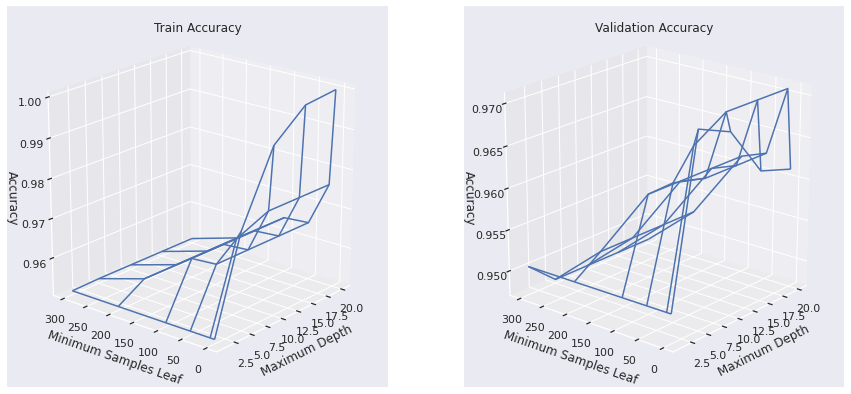

In [ ]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

## Random Forest
For my next three models, I chose Random Forest, AdaBoost, and KNN. After running all three of these models (below) I found that the best validation accuracy out of every model I tried was Random Forest. Afterward, I tuned the features and hyperparameters that resulted in the best possible validation accuracy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=25, random_state=1)
rfc.fit(train_data[features], train_data[target])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
rfc_val_prediction = rfc.predict(validation_data[features])
rfc_train_prediction = rfc.predict(train_data[features])
rfc_val_acc = accuracy_score(rfc_val_prediction, validation_data[target])
rfc_train_acc = accuracy_score(rfc_train_prediction, train_data[target])

print("random forest classifier validation accuracy:", rfc_val_acc)
print("random forest classifier training accuracy:", rfc_train_acc)

random forest classifier validation accuracy: 0.976027397260274
random forest classifier training accuracy: 0.9998572652012561


In [ ]:
rfc_pred = rfc.predict(edx_test[features])
rfc_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
rfc_test_predictions.loc[:, target] = rfc_pred
rfc_test_predictions.to_csv('rfc_submission.csv', index = False)
# files.download('rfc_submission.csv')

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=1000, random_state=1)
adaboost.fit(train_data[features], train_data[target])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=1000, random_state=1)

In [ ]:
adaboost_val_prediction = adaboost.predict(validation_data[features])
adaboost_train_prediction = adaboost.predict(train_data[features])
adaboost_val_acc = accuracy_score(adaboost_val_prediction, validation_data[target])
adaboost_train_acc = accuracy_score(adaboost_train_prediction, train_data[target])

print("adaboost classifier validation accuracy:", adaboost_val_acc)
print("adaboost classifier training accuracy:", adaboost_train_acc)

adaboost classifier validation accuracy: 0.9611872146118722
adaboost classifier training accuracy: 0.9703111618612618


In [ ]:
adaboost_pred = adaboost.predict(edx_test[features])
adaboost_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
adaboost_test_predictions.loc[:, target] = adaboost_pred
adaboost_test_predictions.to_csv('adaboost_submission.csv', index = False)
# files.download('adaboost_submission.csv')

## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(train_data[features], train_data[target])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
neigh_val_prediction = neigh.predict(validation_data[features])
neigh_train_prediction = neigh.predict(train_data[features])
neigh_val_acc = accuracy_score(neigh_val_prediction, validation_data[target])
neigh_train_acc = accuracy_score(neigh_train_prediction, train_data[target])

print("knn classifier validation accuracy:", neigh_val_acc)
print("knn classifier training accuracy:", neigh_train_acc)

knn classifier validation accuracy: 0.966324200913242
knn classifier training accuracy: 0.9701684270625178


In [ ]:
neigh_pred = neigh.predict(edx_test[features])
neigh_test_predictions = edx_id.copy() # edx_test[['userid_DI']].copy()
neigh_test_predictions.loc[:, target] = neigh_pred
neigh_test_predictions.to_csv('neigh_submission.csv', index = False)
# files.download('neigh_submission.csv')

# Plot ROC Curves

Image file saved to /content/ROC-curves.png


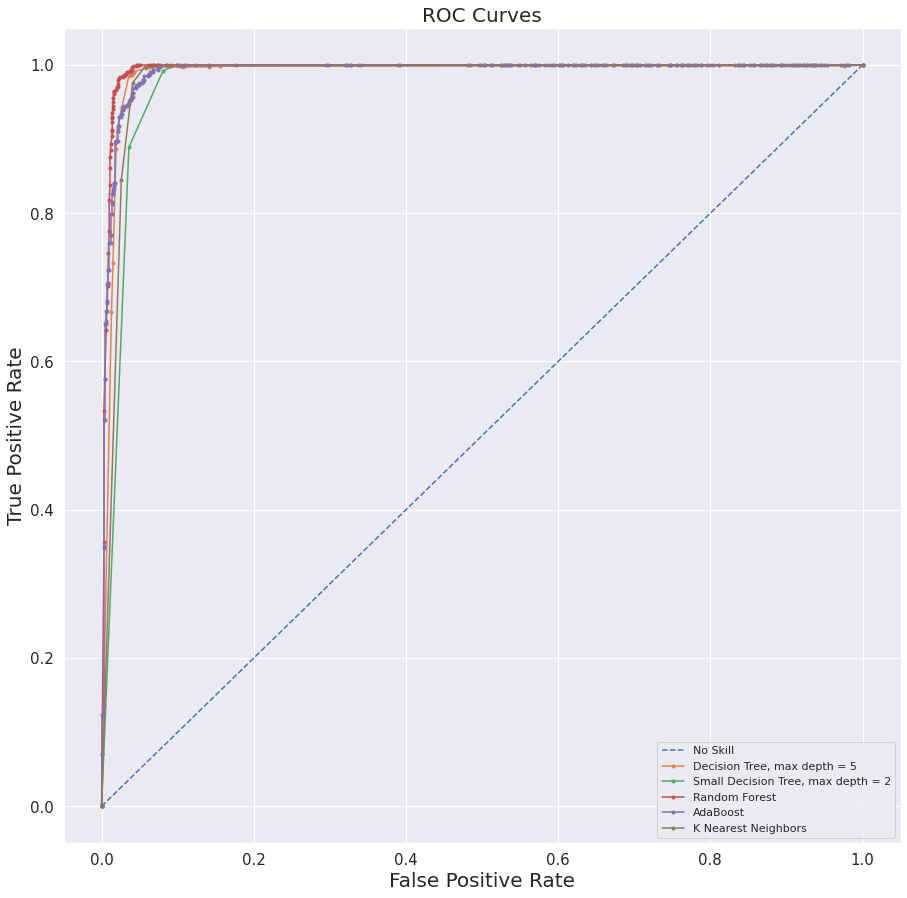

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import os

# get probabilities
ns_probs = [0 for _ in range(len(validation_data))]
decision_tree_probs = decision_tree_model.predict_proba(validation_data[features])
decision_tree_probs = decision_tree_probs[:, 1]

small_tree_probs = small_tree_model.predict_proba(validation_data[features])
small_tree_probs = small_tree_probs[:, 1]

big_tree_probs = big_tree_model.predict_proba(validation_data[features])
big_tree_probs = big_tree_probs[:, 1]

rfc_probs = rfc.predict_proba(validation_data[features])
rfc_probs = rfc_probs[:, 1]

adaboost_probs = adaboost.predict_proba(validation_data[features])
adaboost_probs = adaboost_probs[:, 1]

knn_probs = neigh.predict_proba(validation_data[features])
knn_probs = knn_probs[:, 1]

# get roc curves
ns_fpr, ns_tpr, _ = roc_curve(validation_data[target], ns_probs)
decision_tree_fpr, decision_tree_tpr, _ = roc_curve(validation_data[target], decision_tree_probs)
small_tree_fpr, small_tree_tpr, _ = roc_curve(validation_data[target], small_tree_probs)
big_tree_fpr, big_tree_tpr, _ = roc_curve(validation_data[target], big_tree_probs)

rfc_fpr, rfc_tpr, _ = roc_curve(validation_data[target], rfc_probs)
adaboost_fpr, adaboost_tpr, _ = roc_curve(validation_data[target], adaboost_probs)
knn_fpr, knn_tpr, _ = roc_curve(validation_data[target], knn_probs)


plt.figure(figsize=(15, 15))

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(decision_tree_fpr, decision_tree_tpr, marker='.', label='Decision Tree, max depth = 5')
pyplot.plot(small_tree_fpr, small_tree_tpr, marker='.', label='Small Decision Tree, max depth = 2')
# pyplot.plot(big_tree_fpr, big_tree_tpr, marker='.', label='Big Decision Tree')

pyplot.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')
pyplot.plot(adaboost_fpr, adaboost_tpr, marker='.', label='AdaBoost')
pyplot.plot(knn_fpr, knn_tpr, marker='.', label='K Nearest Neighbors')
pyplot.title("ROC Curves", fontsize=20)
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=20)
pyplot.ylabel('True Positive Rate', fontsize=20)
pyplot.xticks(fontsize=15)
pyplot.yticks(fontsize=15)
# show the legend
pyplot.legend()

filename="ROC-curves.png"
pyplot.savefig(filename)
print("Image file saved to "+os.getcwd()+"/"+filename)

# show the plot
pyplot.show()

from google.colab import files
# files.download(filename)